## Import Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## PATH

In [2]:
weights_path = "yolov4.weights"  
cfg_path = "yolov4.cfg"          
names_path = "coco.names"
video_path = "video/toll_gate.mp4"
points = [(8, 160), (70, 175), (135, 190), (205, 205), (279, 221), (340, 235), (422, 255), (480, 268), (561, 285)]

## Load Video

Total number of frames: 358


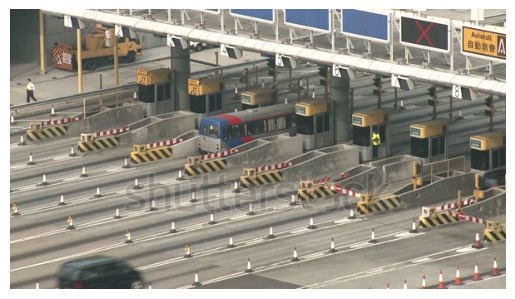

In [3]:
def load_video(video_path):
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    return video
  
video = load_video(video_path)

if video is not None:
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total number of frames: {total_frames}")

if video is not None:
    ret, frame = video.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.axis('off') 
        plt.show()
        
if video is not None:
    video.release()

## Load YOLO

In [ ]:
def load_yolo_model(weights_path=weights_path, cfg_path=cfg_path, names_path=names_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    with open(names_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers, classes

In [ ]:
def draw_gate_lines(frame):  
    for i in range(len(points) - 1):
        cv2.line(frame, points[i], points[i + 1], (0, 255, 0), 3)
        
        mid_x = (points[i][0] + points[i + 1][0]) // 2
        mid_y = (points[i][1] + points[i + 1][1]) // 2
        
        cv2.putText(frame, str(i + 1), (mid_x, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    
    return frame

In [ ]:
def detect_objects(frame, net, output_layers, target_classes=["car", "bus"]):
    height, width, _ = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    
    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]  
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            label = str(classes[class_id])
            
            if confidence > 0.5 and label in target_classes:  
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return [(boxes[i], class_ids[i], confidences[i]) for i in indices]

video = cv2.VideoCapture(video_path)

net, output_layers, classes = load_yolo_model(weights_path, cfg_path, names_path)

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    
    detections = detect_objects(frame, net, output_layers)
    
    for box, class_id, confidence in detections:
        label = str(classes[class_id])
        x, y, w, h = box
        color = (0, 0, 255) if label == "car" else (0, 255, 0) if label == "bus" else (255, 255, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    frame = draw_gate_lines(frame)
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

video.release()

In [ ]:
class CentroidTracker:
    def __init__(self, max_disappeared=5):
        self.nextObjectID = 1
        self.objects = dict()
        self.disappeared = dict()
        self.max_disappeared = max_disappeared

    def register(self, centroid):
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.disappeared[objectID]

    def update(self, rects):
        if len(rects) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.max_disappeared:
                    self.deregister(objectID)
            return self.objects

        input_centroids = np.zeros((len(rects), 2), dtype="int")

        for (i, (x, y, w, h)) in enumerate(rects):
            cX = int((x + x + w) / 2.0)
            cY = int((y + y + h) / 2.0)
            input_centroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(len(input_centroids)):
                self.register(input_centroids[i])
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            D = np.linalg.norm(np.array(objectCentroids) - input_centroids[:, np.newaxis], axis=2)

            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue

                objectID = objectIDs[col]
                self.objects[objectID] = input_centroids[row]
                self.disappeared[objectID] = 0

                usedRows.add(row)
                usedCols.add(col)

            unusedRows = set(range(D.shape[0])).difference(usedRows)
            unusedCols = set(range(D.shape[1])).difference(usedCols)

            if D.shape[0] >= D.shape[1]:
                for row in unusedRows:
                    self.register(input_centroids[row])
            else:
                for col in unusedCols:
                    objectID = objectIDs[col]
                    self.disappeared[objectID] += 1

                    if self.disappeared[objectID] > self.max_disappeared:
                        self.deregister(objectID)

        return self.objects

In [ ]:
def has_crossed_line(centroid, line_y):
    return centroid[1] > line_y

video = cv2.VideoCapture(video_path)

tracker = CentroidTracker()  
car_count = 0
bus_count = 0

gate_y = points[-1][1]  

counted_objects = set()

while video.isOpened():
    ret, frame = video.read()
    if not ret or frame is None:
        break  

    detections = detect_objects(frame, net, output_layers)
    
    rects = [box for (box, class_id, confidence) in detections if classes[class_id] in ["car", "bus"]]
    
    objects = tracker.update(rects)
    
    for objectID, centroid in objects.items():
        vehicle_class = None
        for box, class_id, confidence in detections:
            if classes[class_id] in ["car", "bus"]:
                x, y, w, h = box
                if (x < centroid[0] < x + w) and (y < centroid[1] < y + h):
                    vehicle_class = classes[class_id]
                    break
        
        if has_crossed_line(centroid, gate_y) and objectID not in counted_objects:
            if vehicle_class == "car":
                car_count += 1
            elif vehicle_class == "bus":
                bus_count += 1
            counted_objects.add(objectID)
            
    # VISUALISASI
    for objectID, centroid in objects.items():
        vehicle_class = None
        for box, class_id, confidence in detections:
            if classes[class_id] in ["car", "bus"]:
                x, y, w, h = box
                if (x < centroid[0] < x + w) and (y < centroid[1] < y + h):
                    vehicle_class = classes[class_id]
                    break

        color = (0, 0, 255) if vehicle_class == "car" else (0, 255, 0) if vehicle_class == "bus" else (255, 255, 255)
        cv2.circle(frame, (centroid[0], centroid[1]), 4, color, -1)
        cv2.putText(frame, f"ID {objectID}", (centroid[0] - 10, centroid[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        if vehicle_class:
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{vehicle_class} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    frame = draw_gate_lines(frame)
    frame_width = frame.shape[1]
    cv2.putText(frame, "Created by Minan A", (frame_width - 200, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    cv2.putText(frame, f"Mobil: {car_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(frame, f"Bus  : {bus_count}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

video.release()

In [ ]:
def has_crossed_line(centroid, line_y):
    return centroid[1] > line_y

net, output_layers, classes = load_yolo_model(weights_path, cfg_path, names_path)

video = cv2.VideoCapture(video_path)

frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

output_path = "output_toll_gate.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

tracker = CentroidTracker(max_disappeared=5)  
car_count = 0
bus_count = 0
gate_y = points[-1][1] 

counted_objects = set()

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    detections = detect_objects(frame, net, output_layers)
    
    rects = [box for (box, class_id, confidence) in detections if classes[class_id] in ["car", "bus"]]
    
    objects = tracker.update(rects)
    
    for objectID, centroid in objects.items():
        vehicle_class = None
        for box, class_id, confidence in detections:
            if classes[class_id] in ["car", "bus"]:
                x, y, w, h = box
                if (x < centroid[0] < x + w) and (y < centroid[1] < y + h):
                    vehicle_class = classes[class_id]
                    break
    
        color = (0, 0, 255) if vehicle_class == "car" else (0, 255, 0) if vehicle_class == "bus" else (255, 255, 255)
        cv2.circle(frame, (centroid[0], centroid[1]), 4, color, -1)
        cv2.putText(frame, f"ID {objectID}", (centroid[0] - 10, centroid[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        if vehicle_class:
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{vehicle_class} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            if has_crossed_line(centroid, gate_y) and objectID not in counted_objects:
                if vehicle_class == "car":
                    car_count += 1
                elif vehicle_class == "bus":
                    bus_count += 1
                counted_objects.add(objectID)

    frame = draw_gate_lines(frame)
    frame_width = frame.shape[1]
    cv2.putText(frame, "Created by Minan A", (frame_width - 200, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    cv2.putText(frame, f"Mobil: {car_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(frame, f"Bus  : {bus_count}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    out.write(frame)
    
video.release()
out.release()

print(f"Total Cars: {car_count}")
print(f"Total Buses: {bus_count}")